In [1]:
import scipy.io as spio

from __future__ import division

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib as mpl
from os import path

import logging
import re
import json
import socket

from scipy.io import loadmat

from wyrm.types import Data

from wyrm import plot
#plot.beautify()
from wyrm.types import Data
from wyrm import processing as proc

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
import time
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

In [3]:
TRAIN_A = '../BCI_Comp_III_Wads_2004/data/Subject_A_Train.mat'
TRAIN_B = '../BCI_Comp_III_Wads_2004/data/Subject_B_Train.mat'

TEST_A = '../BCI_Comp_III_Wads_2004/data/Subject_A_Test.mat'
TEST_B = '../BCI_Comp_III_Wads_2004/data/Subject_B_Test.mat'

TRUE_LABELS_A = 'WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU'
TRUE_LABELS_B = 'MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZET1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR'

MATRIX = ['abcdef',
          'ghijkl',
          'mnopqr',
          'stuvwx',
          'yz1234',
          '56789_']

MARKER_DEF_TRAIN = {'target': ['target'], 'nontarget': ['nontarget']}
MARKER_DEF_TEST = {'flashing': ['flashing']}

SEG_IVAL = [0, 700]

In [4]:
def load_bci_data(filename):
    """Load the BCI Competition III Data Set 2.
    This method loads the data set and converts it into Wyrm's ``Data``
    format. Before you use it, you have to download the data set in
    Matlab format and unpack it. The directory with the extracted files
    must contain the ``Subject_*.mat``- and the ``eloc64.txt`` files.
    .. note::
        If you need the true labels of the test sets, you'll have to
        download them separately from
        http://bbci.de/competition/iii/results/index.html#labels
    Parameters
    ----------
    filename : str
        The path to the matlab file to load
    Returns
    -------
    cnt : continuous `Data` object
    Examples
    --------
    >>> dat = load_bcicomp3_ds2('/home/foo/data/Subject_A_Train.mat')
    """
    STIMULUS_CODE = {
        0 : "blankMatrix",
        # cols from left to right
        1 : "agmsy5",
        2 : "bhntz6",
        3 : "ciou17",
        4 : "djpv28",
        5 : "ekqw39",
        6 : "flrx4_",
        # rows from top to bottom
        7 : "abcdef",
        8 : "ghijkl",
        9 : "mnopqr",
        10: "stuvwx",
        11: "yz1234",
        12: "56789_"
        }

    # load the matlab data
    data_mat = loadmat(filename)
    # load the channel names (the same for all datasets
    eloc_file = path.sep.join([path.dirname(filename), 'eloc64.txt'])
    with open(eloc_file) as fh:
        data = fh.read()
    channels = []
    for line in data.splitlines():
        if line:
            chan = line.split()[-1]
            chan = chan.replace('.', '')
            channels.append(chan)
    # fix the channel names, some letters have the wrong capitalization
    for i, s in enumerate(channels):
        s2 = s.upper()
        s2 = s2.replace('Z', 'z')
        s2 = s2.replace('FP', 'Fp')
        channels[i] = s2
    # The signal is recorded with 64 channels, bandpass filtered
    # 0.1-60Hz and digitized at 240Hz. The format is Character Epoch x
    # Samples x Channels
    data = data_mat['Signal']
    data = data.astype('double')
    # For each sample: 1 if a row/colum was flashed, 0 otherwise
    flashing = data_mat['Flashing'].reshape(-1)
    #flashing = np.flatnonzero((np.diff(a) == 1)) + 1
    ##Creates an array where only the initial intensifications of each series appear
    tmp = []
    for i, _ in enumerate(flashing):
        if i == 0:
            tmp.append(flashing[i])
            continue
        if flashing[i] == flashing[i-1] == 1:
            tmp.append(0)
            continue
        tmp.append(flashing[i])
    flashing = np.array(tmp)
    # For each sample: 0 when no row/colum was intensified,
    # 1..6 for intensified columns, 7..12 for intensified rows
    stimulus_code = data_mat['StimulusCode'].reshape(-1)
    stimulus_code = stimulus_code[flashing == 1]
    # 0 if no row/col was intensified or the intensified did not contain
    # the target character, 1 otherwise
    stimulus_type = data_mat.get('StimulusType', np.array([])).reshape(-1)
    # The target characters
    target_chars = data_mat.get('TargetChar', np.array([])).reshape(-1)
    fs = 240
    data = data.reshape(-1, 64)
    timeaxis = np.linspace(0, data.shape[0] / fs * 1000, data.shape[0], endpoint=False)
    dat = Data(data=data, axes=[timeaxis, channels], names=['time', 'channel'], units=['ms', '#'])
    dat.fs = fs
    # preparing the markers
    target_mask = np.logical_and((flashing == 1), (stimulus_type == 1)) if len(stimulus_type) > 0 else []
    nontarget_mask = np.logical_and((flashing == 1), (stimulus_type == 0)) if len(stimulus_type) > 0 else []
    flashing = (flashing == 1)
    flashing = [[i, 'flashing'] for i in timeaxis[flashing]]
    targets = [[i, 'target'] for i in timeaxis[target_mask]]
    nontargets = [[i, 'nontarget'] for i in timeaxis[nontarget_mask]]
    dat.stimulus_code = stimulus_code[:]
    stim = []
    for i,_ in enumerate(flashing):
        stim.append([flashing[i][0], STIMULUS_CODE[stimulus_code[i]]])
    stimulus_code = stim
    #stimulus_code = zip([t for t, _ in flashing], [STIMULUS_CODE[i] for i in stimulus_code])
    #Raises error "TypeError: '<' not supported between instances of 'tuple' and 'list'" when calling sort() 
    #stimulus_code =[[t for t,_ in flashing], [STIMULUS_CODE[i] for i in stimulus_code]]
    #print(type(stimulus_code), type(flashing), type(targets), type(nontargets))
    markers = flashing[:]
    markers.extend(targets)
    markers.extend(nontargets)
    markers.extend(stimulus_code)
    markers.sort()
    dat.markers = markers[:]
    return dat


In [5]:
def preprocessing_simple(dat, MRK_DEF, *args, **kwargs):
    """Simple preprocessing that reaches 97% accuracy.
    """
    fs_n = dat.fs / 2
    b, a = proc.signal.butter(5, [10 / fs_n], btype='low')
    dat = proc.filtfilt(dat, b, a)
   
    dat = proc.subsample(dat, 20)
    epo = proc.segment_dat(dat, MRK_DEF, SEG_IVAL)
    fv = proc.create_feature_vectors(epo)
    return fv, epo

In [6]:
def predict_character(pred, n_characters, fv_test, labels):
    pred_target = pred
    #unscramble_idx = fv_test.stimulus_code.reshape(100, 15, 12).argsort()
    unscramble_idx = fv_test.stimulus_code.reshape(n_characters, -1, 12).argsort()
    static_idx = np.indices(unscramble_idx.shape)
    #lda_out_prob = pred.reshape(100, 15, 12)
    lda_out_prob = pred.reshape(n_characters, -1, 12)
    lda_out_prob = lda_out_prob[static_idx[0], static_idx[1], unscramble_idx]

    # destil the result of the 15 runs
    lda_out_prob = lda_out_prob.sum(axis=1)
    lda_out_prob = lda_out_prob.argsort()


    cols = lda_out_prob[lda_out_prob <= 5].reshape(n_characters, -1)
    rows = lda_out_prob[lda_out_prob > 5].reshape(n_characters, -1)
    text = ''
    for i in range(n_characters):
        row = rows[i][-1]-6
        col = cols[i][-1]
        letter = MATRIX[row][col]
        text += letter
    print()
    print('Constructed labels: %s' % text.upper())
    print('True labels       : %s' % labels)
    a = np.array(list(text.upper()))
    b = np.array(list(labels))
    accuracy = np.count_nonzero(a == b) / len(a)
    print('Accuracy: %.1f%%' % (accuracy * 100))
    

In [7]:
dat_train = load_bci_data(TRAIN_B)
dat_test = load_bci_data(TEST_B)

In [8]:
fv_train, epo = preprocessing_simple(dat_train, MARKER_DEF_TRAIN, SEG_IVAL)
fv_test, _ = preprocessing_simple(dat_test, MARKER_DEF_TEST, SEG_IVAL)

In [9]:
x = fv_train.data #traininig samples
y = fv_train.axes[0] #class labels

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.3, train_size = 0.7)


In [11]:
x_test = fv_test.data #traininig samples
y_test = fv_test.axes[0] #class labels

## Grid Search for each Kernel

In [13]:
kernels = ['linear', 'sigmoid', 'rbf', 'poly']
# Gaussian Kernel
C_range = np.logspace(-5, 5, 6, endpoint = True, base = 10)
gamma_range = np.logspace(-11, 3, 8, endpoint = True, base = 10)
param_grid = dict(gamma=gamma_range, C=C_range)

In [14]:
parameters = {}
parameters['rbf'] = param_grid

In [17]:
parameters['linear'] = dict(C = C_range)

In [12]:
from sklearn.calibration import CalibratedClassifierCV
import time
def SVM(X_train, y_train, X_valid, y_valid):
    clf = CalibratedClassifierCV(base_estimator=LinearSVC(), cv=2)
    t_start = time.clock()
    clf.fit(x, y)
    pred = clf.predict_proba(x_test)
    pred_class = clf.predict(x_test)
    t_end = time.clock()
    print(clf.score(x_test, y_test), 'time: {} seconds'.format(t_end - t_start))
    return pred, pred_class


In [ ]:
from sklearn.preprocessing import normalize
x_norm = normalize(x, axis = 1)
x_test_norm = normalize(x_test, axis = 1)

In [ ]:
pred, pred_class = SVM(x, y, x_test, y_test)
pred_norm, pred_class_norm = SVM(x_norm, y, x_test_norm, y_test)

In [ ]:
predict_character(pred[:,1], 100, fv_test, TRUE_LABELS_B)
predict_character(pred_norm[:,1], 100, fv_test, TRUE_LABELS_B)

In [ ]:
clf = CalibratedClassifierCV(base_estimator=LinearSVC(C = 1), cv=2)
t_start = time.clock()
clf.fit(x_norm, y)
pred_norm = clf.predict_proba(x_test_norm)
t_end = time.clock()
print(clf.score(x_test_norm, y_test), 'time: {} seconds'.format(t_end - t_start))


In [ ]:
predict_character(pred_B[:,1], 100, fv_test,TRUE_LABELS_B)

In [ ]:
predict_character(pred_norm[:,1], 100, fv_test, TRUE_LABELS_B)

## Gaussian Kernel Grid-CV Search

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(x)
X = X[:5000,:]
Y = y[:5000]

In [23]:
from sklearn.model_selection import GridSearchCV

C_range = np.logspace(-5, 5, 6, endpoint = True, base = 10)
gamma_range = np.logspace(-11, 3, 8, endpoint = True, base = 10)
param_grid = dict(gamma=gamma_range, C=C_range)
#TODO: poner class-weight = 'balanced'
grid2 = GridSearchCV(SVC(), param_grid=param_grid, cv=3, verbose = 3) 
grid2.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid2.best_params_, grid2.best_score_))

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] C=1e-05, gamma=1e-11 ............................................
[CV] ............. C=1e-05, gamma=1e-11, score=0.832820, total=  29.0s
[CV] C=1e-05, gamma=1e-11 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.8s remaining:    0.0s


[CV] ............. C=1e-05, gamma=1e-11, score=0.832773, total=  28.5s
[CV] C=1e-05, gamma=1e-11 ............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV] ............. C=1e-05, gamma=1e-11, score=0.833006, total=  28.7s
[CV] C=1e-05, gamma=1e-09 ............................................
[CV] ............. C=1e-05, gamma=1e-09, score=0.832820, total=  28.8s
[CV] C=1e-05, gamma=1e-09 ............................................
[CV] ............. C=1e-05, gamma=1e-09, score=0.832773, total=  28.6s
[CV] C=1e-05, gamma=1e-09 ............................................
[CV] ............. C=1e-05, gamma=1e-09, score=0.833006, total=  28.5s
[CV] C=1e-05, gamma=1e-07 ............................................
[CV] ............. C=1e-05, gamma=1e-07, score=0.832820, total=  28.9s
[CV] C=1e-05, gamma=1e-07 ............................................
[CV] ............. C=1e-05, gamma=1e-07, score=0.832773, total=  28.9s
[CV] C=1e-05, gamma=1e-07 ............................................
[CV] ............. C=1e-05, gamma=1e-07, score=0.833006, total=  28.6s
[CV] C=1e-05, gamma=1e-05 ............................................
[CV] .

[CV] ............... C=0.1, gamma=0.001, score=0.832820, total= 1.4min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=0.001, score=0.832773, total= 1.5min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=0.001, score=0.833006, total= 1.4min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................. C=0.1, gamma=0.1, score=0.832820, total= 1.4min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................. C=0.1, gamma=0.1, score=0.832773, total= 1.4min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................. C=0.1, gamma=0.1, score=0.833006, total= 1.4min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] ................ C=0.1, gamma=10.0, score=0.832820, total= 1.4min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] .

[CV] ........... C=1000.0, gamma=1000.0, score=0.832773, total= 1.5min
[CV] C=1000.0, gamma=1000.0 ..........................................
[CV] ........... C=1000.0, gamma=1000.0, score=0.833006, total= 1.6min
[CV] C=100000.0, gamma=1e-11 .........................................
[CV] .......... C=100000.0, gamma=1e-11, score=0.832820, total=  35.9s
[CV] C=100000.0, gamma=1e-11 .........................................
[CV] .......... C=100000.0, gamma=1e-11, score=0.832773, total=  35.8s
[CV] C=100000.0, gamma=1e-11 .........................................
[CV] .......... C=100000.0, gamma=1e-11, score=0.833006, total=  36.8s
[CV] C=100000.0, gamma=1e-09 .........................................
[CV] .......... C=100000.0, gamma=1e-09, score=0.865024, total=  46.1s
[CV] C=100000.0, gamma=1e-09 .........................................
[CV] .......... C=100000.0, gamma=1e-09, score=0.870308, total=  44.1s
[CV] C=100000.0, gamma=1e-09 .........................................
[CV] .

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 223.6min finished


NameError: name 'grid' is not defined

In [24]:
print("The best parameters are %s with a score of %0.2f"
      % (grid2.best_params_, grid2.best_score_))

The best parameters are {'C': 100000.0, 'gamma': 1.0000000000000001e-09} with a score of 0.87


C:\Users\sofis\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 720x1440 with 0 Axes>

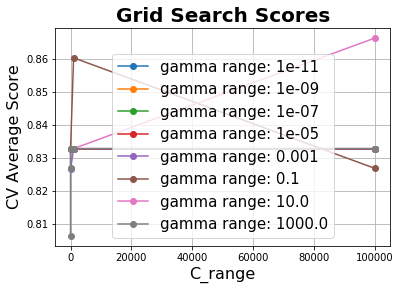

In [30]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Calling Method 
plot_grid_search(grid2.cv_results_, C_range, gamma_range, 'C_range', 'gamma range')

In [77]:

C_range = np.logspace(-5, 15, 3, endpoint = True, base = 10)
gamma_range = np.logspace(-15, 3, 3, endpoint = True, base = 10)

In [93]:
from sklearn.model_selection import GridSearchCV

C_range = np.logspace(-5, 15, 11, endpoint = True, base = 2)
gamma_range = np.logspace(-15, 3, 10, endpoint = True, base = 2)
param_grid = dict(gamma=gamma_range, C=C_range)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=3, verbose = 3)
grid.fit(X, Y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

Fitting 3 folds for each of 110 candidates, totalling 330 fits
[CV] C=0.03125, gamma=3.0517578125e-05 ...............................
[CV]  C=0.03125, gamma=3.0517578125e-05, score=0.8332333533293341, total=   6.7s
[CV] C=0.03125, gamma=3.0517578125e-05 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s remaining:    0.0s


[CV]  C=0.03125, gamma=3.0517578125e-05, score=0.8332333533293341, total=   6.5s
[CV] C=0.03125, gamma=3.0517578125e-05 ...............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.8s remaining:    0.0s


[CV]  C=0.03125, gamma=3.0517578125e-05, score=0.8337334933973589, total=   6.5s
[CV] C=0.03125, gamma=0.0001220703125 ................................
[CV]  C=0.03125, gamma=0.0001220703125, score=0.8332333533293341, total=   7.8s
[CV] C=0.03125, gamma=0.0001220703125 ................................
[CV]  C=0.03125, gamma=0.0001220703125, score=0.8332333533293341, total=   7.9s
[CV] C=0.03125, gamma=0.0001220703125 ................................
[CV]  C=0.03125, gamma=0.0001220703125, score=0.8337334933973589, total=   7.6s
[CV] C=0.03125, gamma=0.00048828125 ..................................
[CV]  C=0.03125, gamma=0.00048828125, score=0.8332333533293341, total=  10.6s
[CV] C=0.03125, gamma=0.00048828125 ..................................
[CV]  C=0.03125, gamma=0.00048828125, score=0.8332333533293341, total=  10.7s
[CV] C=0.03125, gamma=0.00048828125 ..................................
[CV]  C=0.03125, gamma=0.00048828125, score=0.8337334933973589, total=   9.8s
[CV] C=0.03125, gam

[CV] ..... C=0.125, gamma=8.0, score=0.8337334933973589, total=  18.7s
[CV] C=0.5, gamma=3.0517578125e-05 ...................................
[CV]  C=0.5, gamma=3.0517578125e-05, score=0.8332333533293341, total=   8.1s
[CV] C=0.5, gamma=3.0517578125e-05 ...................................
[CV]  C=0.5, gamma=3.0517578125e-05, score=0.8332333533293341, total=   7.9s
[CV] C=0.5, gamma=3.0517578125e-05 ...................................
[CV]  C=0.5, gamma=3.0517578125e-05, score=0.8337334933973589, total=   8.1s
[CV] C=0.5, gamma=0.0001220703125 ....................................
[CV]  C=0.5, gamma=0.0001220703125, score=0.8332333533293341, total=   8.7s
[CV] C=0.5, gamma=0.0001220703125 ....................................
[CV]  C=0.5, gamma=0.0001220703125, score=0.8332333533293341, total=   8.9s
[CV] C=0.5, gamma=0.0001220703125 ....................................
[CV]  C=0.5, gamma=0.0001220703125, score=0.8337334933973589, total=   9.1s
[CV] C=0.5, gamma=0.00048828125 ............

[CV] ....... C=2.0, gamma=8.0, score=0.8332333533293341, total=  20.0s
[CV] C=2.0, gamma=8.0 ................................................
[CV] ....... C=2.0, gamma=8.0, score=0.8332333533293341, total=  19.7s
[CV] C=2.0, gamma=8.0 ................................................
[CV] ....... C=2.0, gamma=8.0, score=0.8337334933973589, total=  19.5s
[CV] C=8.0, gamma=3.0517578125e-05 ...................................
[CV]  C=8.0, gamma=3.0517578125e-05, score=0.8332333533293341, total=   8.3s
[CV] C=8.0, gamma=3.0517578125e-05 ...................................
[CV]  C=8.0, gamma=3.0517578125e-05, score=0.8332333533293341, total=   8.5s
[CV] C=8.0, gamma=3.0517578125e-05 ...................................
[CV]  C=8.0, gamma=3.0517578125e-05, score=0.8337334933973589, total=   9.0s
[CV] C=8.0, gamma=0.0001220703125 ....................................
[CV]  C=8.0, gamma=0.0001220703125, score=0.8326334733053389, total=   9.3s
[CV] C=8.0, gamma=0.0001220703125 ....................

[CV] ...... C=32.0, gamma=2.0, score=0.8332333533293341, total=  19.7s
[CV] C=32.0, gamma=2.0 ...............................................
[CV] ...... C=32.0, gamma=2.0, score=0.8332333533293341, total=  19.8s
[CV] C=32.0, gamma=2.0 ...............................................
[CV] ...... C=32.0, gamma=2.0, score=0.8337334933973589, total=  19.9s
[CV] C=32.0, gamma=8.0 ...............................................
[CV] ...... C=32.0, gamma=8.0, score=0.8332333533293341, total=  22.1s
[CV] C=32.0, gamma=8.0 ...............................................
[CV] ...... C=32.0, gamma=8.0, score=0.8332333533293341, total=  23.8s
[CV] C=32.0, gamma=8.0 ...............................................
[CV] ...... C=32.0, gamma=8.0, score=0.8337334933973589, total=  23.2s
[CV] C=128.0, gamma=3.0517578125e-05 .................................
[CV]  C=128.0, gamma=3.0517578125e-05, score=0.8374325134973005, total=   9.8s
[CV] C=128.0, gamma=3.0517578125e-05 ................................

[CV] ..... C=512.0, gamma=0.5, score=0.8332333533293341, total=  19.6s
[CV] C=512.0, gamma=0.5 ..............................................
[CV] ..... C=512.0, gamma=0.5, score=0.8332333533293341, total=  20.5s
[CV] C=512.0, gamma=0.5 ..............................................
[CV] ..... C=512.0, gamma=0.5, score=0.8337334933973589, total=  20.2s
[CV] C=512.0, gamma=2.0 ..............................................
[CV] ..... C=512.0, gamma=2.0, score=0.8332333533293341, total=  19.9s
[CV] C=512.0, gamma=2.0 ..............................................
[CV] ..... C=512.0, gamma=2.0, score=0.8332333533293341, total=  20.9s
[CV] C=512.0, gamma=2.0 ..............................................
[CV] ..... C=512.0, gamma=2.0, score=0.8337334933973589, total=  20.1s
[CV] C=512.0, gamma=8.0 ..............................................
[CV] ..... C=512.0, gamma=8.0, score=0.8332333533293341, total=  19.9s
[CV] C=512.0, gamma=8.0 ..............................................
[CV] .

[CV] .. C=8192.0, gamma=0.125, score=0.8332333533293341, total=  21.5s
[CV] C=8192.0, gamma=0.125 ...........................................
[CV] .. C=8192.0, gamma=0.125, score=0.8332333533293341, total=  21.3s
[CV] C=8192.0, gamma=0.125 ...........................................
[CV] .. C=8192.0, gamma=0.125, score=0.8337334933973589, total=  21.5s
[CV] C=8192.0, gamma=0.5 .............................................
[CV] .... C=8192.0, gamma=0.5, score=0.8332333533293341, total=  21.9s
[CV] C=8192.0, gamma=0.5 .............................................
[CV] .... C=8192.0, gamma=0.5, score=0.8332333533293341, total=  20.3s
[CV] C=8192.0, gamma=0.5 .............................................
[CV] .... C=8192.0, gamma=0.5, score=0.8337334933973589, total=  21.2s
[CV] C=8192.0, gamma=2.0 .............................................
[CV] .... C=8192.0, gamma=2.0, score=0.8332333533293341, total=  21.5s
[CV] C=8192.0, gamma=2.0 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done 330 out of 330 | elapsed: 150.6min finished


The best parameters are {'C': 512.0, 'gamma': 3.0517578125e-05} with a score of 0.85


In [30]:
from sklearn.model_selection import GridSearchCV

C_range = np.logspace(-1, 10, 6,  base = 10)
gamma_range = np.logspace(-7, 1, 5, endpoint = True, base = 10)
param_grid = dict(gamma=gamma_range, C=C_range)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=3, scoring = ['accuracy', 'roc_auc'], refit = 'accuracy', verbose = 3)
grid.fit(X, Y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] C=0.1, gamma=1e-07 ..............................................
[CV]  C=0.1, gamma=1e-07, accuracy=0.8332333533293341, roc_auc=0.7112642499391415, total=  18.4s
[CV] C=0.1, gamma=1e-07 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.4s remaining:    0.0s


[CV]  C=0.1, gamma=1e-07, accuracy=0.8332333533293341, roc_auc=0.6605756431571805, total=  17.9s
[CV] C=0.1, gamma=1e-07 ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV]  C=0.1, gamma=1e-07, accuracy=0.8337334933973589, roc_auc=0.7015279932840031, total=  18.2s
[CV] C=0.1, gamma=1e-05 ..............................................
[CV]  C=0.1, gamma=1e-05, accuracy=0.8332333533293341, roc_auc=0.7530752935448618, total=  19.2s
[CV] C=0.1, gamma=1e-05 ..............................................
[CV]  C=0.1, gamma=1e-05, accuracy=0.8332333533293341, roc_auc=0.7408103754577332, total=  19.7s
[CV] C=0.1, gamma=1e-05 ..............................................
[CV]  C=0.1, gamma=1e-05, accuracy=0.8337334933973589, roc_auc=0.7820159946771045, total=  15.6s
[CV] C=0.1, gamma=0.001 ..............................................
[CV]  C=0.1, gamma=0.001, accuracy=0.8332333533293341, roc_auc=0.73643374717073, total=  27.7s
[CV] C=0.1, gamma=0.001 ..............................................
[CV]  C=0.1, gamma=0.001, accuracy=0.8332333533293341, roc_auc=0.7291980670323353, total=  26.0s
[CV] C=0.1, gamma=0.001 .........................................

[CV]  C=398107.17055349774, gamma=1e-05, accuracy=0.7918416316736653, roc_auc=0.7247981312574131, total=  31.0s
[CV] C=398107.17055349774, gamma=1e-05 ...............................
[CV]  C=398107.17055349774, gamma=1e-05, accuracy=0.8085234093637454, roc_auc=0.7731115806764339, total=  32.3s
[CV] C=398107.17055349774, gamma=0.001 ...............................
[CV]  C=398107.17055349774, gamma=0.001, accuracy=0.8200359928014397, roc_auc=0.7259531467698412, total=  27.2s
[CV] C=398107.17055349774, gamma=0.001 ...............................
[CV]  C=398107.17055349774, gamma=0.001, accuracy=0.8176364727054589, roc_auc=0.7205406301308845, total=  28.7s
[CV] C=398107.17055349774, gamma=0.001 ...............................
[CV]  C=398107.17055349774, gamma=0.001, accuracy=0.8289315726290516, roc_auc=0.7441995254098084, total=  25.8s
[CV] C=398107.17055349774, gamma=0.1 .................................
[CV]  C=398107.17055349774, gamma=0.1, accuracy=0.8332333533293341, roc_auc=0.5156056

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 105.3min finished


The best parameters are {'C': 2511.886431509582, 'gamma': 1e-05} with a score of 0.86


In [25]:
from matplotlib.colors import Normalize
# Utility function to move the midpoint of a colormap to be around
# the values of interest.

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [66]:
from seaborn import heatmap

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('C:\\Users\\sofis\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('C:\\Users\\sofis\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000


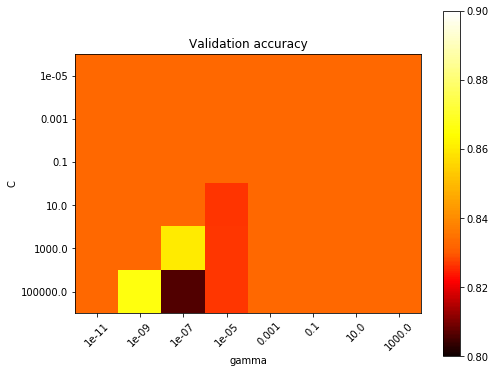

In [26]:
# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.
# scores = grid.cv_results_['mean_test_roc_auc'].reshape(5,5)

scores = grid2.cv_results_['mean_test_score'].reshape(len(C_range), 8)
                                                    # len(gamma_range))
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.8, midpoint=0.83, vmax = 0.9))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()


In [62]:
scores

array([[0.8334, 0.8334, 0.8334],
       [0.8334, 0.8334, 0.8334],
       [0.8052, 0.8334, 0.8334]])

# Unbalanced classes, different soft margin constants

In [18]:
n_target = x_B[y_B == 1].shape[0]
n_nontarget = x_B[y_B == 0].shape[0]

In [19]:
C_nontarget = 1
C_target = n_nontarget/n_target * C_nontarget
C = {0 : C_nontarget, 1 : C_target}

In [20]:
clf = CalibratedClassifierCV(base_estimator=LinearSVC(C = 1, class_weight = C), cv=2)
t_start = time.clock()
clf.fit(x_norm_B, y_B)
pred = clf.predict_proba(x_test_norm_B)
t_end = time.clock()
print(clf.score(x_test_norm_B, y_test_B), 'time: {} seconds'.format(t_end - t_start))

0.9159444444444444 time: 5.857566110596586 seconds


In [21]:
predict_character(pred[:,1], 100, fv_test_B, TRUE_LABELS_B)


Constructed labels: MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZEY1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR
True labels       : MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZET1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR
Accuracy: 99.0%


## Con menos canales

In [22]:
def sel_channels(dat, c_list, chanaxis=-1):
    chan_mask = np.array([False for i in range(len(dat.axes[chanaxis]))])
    for c in c_list:
        idx = list(dat.axes[-1]).index(c)
        chan_mask[idx] = True
    data = dat.data.compress(chan_mask, chanaxis)
    channs = dat.axes[chanaxis][chan_mask]
    axes = dat.axes[:]
    axes[-1] = channs
    #class_names = dat.class_names
    #dat.class_names = class_names
    return dat.copy(data=data, axes=axes)


In [23]:
channel_list = ['Cz', 'P3', 'Pz', 'P4', 'POz', 'O1', 'Oz', 'O2']
dat_train_B = sel_channels(dat_train_B, channel_list)
dat_test_B = sel_channels(dat_test_B, channel_list)

fv_train_B, epo_B = preprocessing_simple(dat_train_B, MARKER_DEF_TRAIN, SEG_IVAL)
fv_test_B, _ = preprocessing_simple(dat_test_B, MARKER_DEF_TEST, SEG_IVAL)

In [24]:
x_B = fv_train_B.data #traininig samples
y_B = fv_train_B.axes[0] #class labels

In [25]:
x_test_B = fv_test_B.data #traininig samples
y_test_B = fv_test_B.axes[0] #class labels

In [26]:
from sklearn.preprocessing import normalize
x_norm_B = normalize(x_B, axis = 1)
x_test_norm_B = normalize(x_test_B, axis = 1)

In [27]:
pred_B, pred_class_B = SVM(x_B, y_B, x_test_B, y_test_B)
pred_B_norm, pred_class_norm_B = SVM(x_norm_B, y_B, x_test_norm_B, y_test_B)

0.9979444444444444 time: 5.912300632832171 seconds
0.9652222222222222 time: 0.4231089559065424 seconds


In [28]:
predict_character(pred_B[:,1], 100, fv_test_B, TRUE_LABELS_B)
predict_character(pred_B_norm[:,1], 100, fv_test_B, TRUE_LABELS_B)


Constructed labels: MDRMIROOMUPJPXDOHUVFNORYW3GLOO6TOFFKFFTWEOOCLZOP3ROEGZDM1Y19EKX65QUXU7NAU_4YCJCVFNDQXOHERV2B5KCDIDNR
True labels       : MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZET1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR
Accuracy: 72.0%

Constructed labels: MERSIROOGUNJOXJOHUPRBORXR3GLOO6CUFDKFFTWCOOALZOP9ROCGZBO1Y19EWX65QUYU7NAE_4SCJDVDNAQXOJBEV2B5EFDIDNR
True labels       : MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZET1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR
Accuracy: 81.0%


# MLP

In [16]:
param_grid = {'alpha': 10.0**(-np.arange(1,7)), 'learning_rate_init': [0.05, 0.01, 0.005, 0.001]}
#  {'solver': ['adam'], 'alpha': 10.0**(-np.arange(1,7)), 'learning_rate_init': [0.05, 0.01, 0.005, 0.001]}]
 

In [21]:
from sklearn.grid_search import GridSearchCV
gs = GridSearchCV(MLPClassifier(), param_grid,  verbose = 4, cv = 2, scoring = 'accuracy', refit = True)
gs.fit(x, y)
print("The best parameters are %s with a score of %0.2f"
      % (gs.best_params_, gs.best_score_))

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV] alpha=0.1, learning_rate_init=0.05 ..............................
[CV] ..... alpha=0.1, learning_rate_init=0.05, score=0.832549 -   3.3s
[CV] alpha=0.1, learning_rate_init=0.05 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV] ..... alpha=0.1, learning_rate_init=0.05, score=0.829412 -   3.8s
[CV] alpha=0.1, learning_rate_init=0.01 ..............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s


[CV] ..... alpha=0.1, learning_rate_init=0.01, score=0.837908 -   4.8s
[CV] alpha=0.1, learning_rate_init=0.01 ..............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.2s remaining:    0.0s


[CV] ..... alpha=0.1, learning_rate_init=0.01, score=0.788366 -   5.3s
[CV] alpha=0.1, learning_rate_init=0.005 .............................
[CV] .... alpha=0.1, learning_rate_init=0.005, score=0.710065 -   3.6s
[CV] alpha=0.1, learning_rate_init=0.005 .............................
[CV] .... alpha=0.1, learning_rate_init=0.005, score=0.819869 -   4.8s
[CV] alpha=0.1, learning_rate_init=0.001 .............................
[CV] .... alpha=0.1, learning_rate_init=0.001, score=0.766144 -   4.2s
[CV] alpha=0.1, learning_rate_init=0.001 .............................
[CV] .... alpha=0.1, learning_rate_init=0.001, score=0.792680 -   5.2s
[CV] alpha=0.01, learning_rate_init=0.05 .............................
[CV] .... alpha=0.01, learning_rate_init=0.05, score=0.832680 -   2.1s
[CV] alpha=0.01, learning_rate_init=0.05 .............................
[CV] .... alpha=0.01, learning_rate_init=0.05, score=0.818039 -   3.7s
[CV] alpha=0.01, learning_rate_init=0.01 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  3.2min finished


The best parameters are {'alpha': 0.1, 'learning_rate_init': 0.05} with a score of 0.83
